# QLora 기법을 활용한 PEFT

LLM과 같은 대규모 모델에서 더욱 효율 적인 미세조정 즉, PEFT(Parameter-Efficient Fine-Tuning)을 하기위한 가장 대표적인 방식이 바로 Lora 방식 입니다.

해당 예시에서는 허깅페이스로 모델을 불러온뒤 LoraConfig를 활용하여 구글의 gemma3 모델을 한국어 뉴스 요약 테스크로 PEFT 진행하는 과정을 살펴봅니다.



## 초기화 과정

#### 라이브러리 설치

1. `transformers > 4.50.1` : gemma3 가 포함된 최신 transformers 버전
2. `bitsandbytes` : 양자화를 위한 라이브러리
3. `trl` : SFTTrainer를 활용하여 학습하기 위한 라이브러리
4. `datasets` :  Hugging Face Hub에 저장된 데이터세트를 불러오기 위한 라이브러리

다음 라이브러리 설치후 세션 재시작


In [1]:
%pip install "transformers" "bitsandbytes" "trl" "datasets" "evaluate" "matplotlib-venn"

Note: you may need to restart the kernel to use updated packages.


허깅페이스 로그인


In [ ]:
from huggingface_hub import login

# 위젯 대신 login 함수 안에 토큰을 직접 넣어서 로그인합니다.
# "hf_..." 부분에 복사해둔 토큰을 따옴표 안에 넣어주세요.
login(token="hf_...")

# 만약 모델을 업로드(저장)까지 해야 한다면 아래처럼 옵션을 추가할 수 있습니다.
# login(token="hf_...", write_permission=True)

# 1. Gemma 모델 PEFT

[Gemma3](https://developers.googleblog.com/en/gemma-explained-whats-new-in-gemma-3/) 모델은 구글에서 Gemini 모델을 만드는 데 사용된 것과 동일한 연구 및 기술로 구축한 GPT 기반의 최신 텍스트 생성 모델입니다.

Gemma3 모델은 멀티모달로, 텍스트와 이미지 입력을 처리하고 텍스트 출력을 생성가능 합니다. 예시에서는 이미지 입력은 활용하지 않고 텍스트 입력만을 활용하여 문장 요약에 최적화된 모델로 미세조정 합니다.

먼저 모델을 가져오기 전에 [Gemma3](https://huggingface.co/google/gemma-3-1b-it)에서 **라이센스 동의** 후, 로그인 해주어야 합니다.

**Gemma 모델 설명**


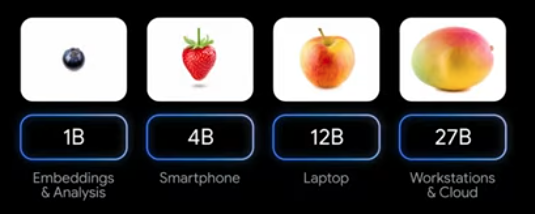


https://huggingface.co/models?sort=trending&search=gemma

https://www.youtube.com/watch?v=qcjrduz_YS8


### 양자화 하여 모델 로드

LLM 모델을 더욱 특정 테스크에 최적화하여 더욱 효율 적으로 사용하기 위해 모델의 크기를 줄이는 **경량화** 작업을 진행할 수 있습니다.  

모델의 경령화 작업중 가장 간단하고 효율적인 방법중 하나가 사용 비트가 큰 실수(float64)타입으로 저장되는 파라미터를 작은 비트의 정수(int4, int8)등으로 줄이는 **양자화** 입니다.

예) "32비트 숫자를 4비트 숫자로 압축해서 메모리 절약"

In [3]:
from transformers import AutoTokenizer, BitsAndBytesConfig, AutoModelForCausalLM
import torch
model_id = "google/gemma-3-1b-it"

# 4비트 양자화: https://huggingface.co/docs/transformers/ko/quantization/bitsandbytes#normal-float-4-(nf4)
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,                              # 가중치를 4_bit 양자화
    bnb_4bit_compute_dtype=torch.float16,           # 연산 텐서는 float16 사용
    bnb_4bit_quant_type='nf4',                      # NormalFloat4 양자화 타입(분포를 유연하게)
    bnb_4bit_use_double_quant=True                  # double quantization 사용(양자화 노이즈를 보다 잘 보정하려는 목적)
)

# 양자화를 적용하여 모델 로드: https://huggingface.co/docs/transformers/en/main_classes/model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,        # 양자와 적용
    attn_implementation='eager'                     # 안정적인 eager 어텐션 사용
).eval()

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_id)

print(model)

Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear4bit(in_features=1152, out_features=1024, bias=False)
          (k_proj): Linear4bit(in_features=1152, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=1152, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=1024, out_features=1152, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear4bit(in_features=1152, out_features=6912, bias=False)
          (up_proj): Linear4bit(in_features=1152, out_features=6912, bias=False)
          (down_proj): Linear4bit(in_features=6912, out_features=1152, bias=False)
          (act_fn): GELUTanh()
        )
        (input_layernor

### 텍스트 생성해보기

양자화된 모델로 부터 텍스트가 잘 생성되는지 테스트해 봅니다.  

`gemma-3-1b-it` 모델은 챗봇 역할로써 한번 미세조정이 된 모델이므로 입력 프롬프트 템플릿에 맞춰 텍스트를 입력해주어 좀더 명확하게 사용할 수 있습니다.

AutoTokenizer로 토크나이져를 생성한 후 `apply_chat_template()` 함수를 통해 역할이 지정된 프롬프트 텍스트를 토큰화 하고 모델 입력에 맞게 구성해 줍니다.

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

messages = [
    [
        {
            "role": "system",
            "content": "마크다운 표기 없이 일반 텍스트 형식으로 답변 작성"
        },
        {
            "role": "user",
            "content": "LLM과 허깅페이스에 대한 간략한 설명"
        },
    ],
]

inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device).to(torch.bfloat16)

inputs

Attempting to cast a BatchEncoding to type torch.bfloat16. This is not supported.


{'input_ids': tensor([[     2,    105,   2364,    107, 238098, 238572, 164809,  41176, 237351,
          89551,  75834, 236743, 243007,  34718, 184412,   7246, 231757, 107854,
            108,   2182, 236792, 237842,  92475, 246489, 204451, 237223,  32102,
          43255, 241866, 237384,  59587,    106,    107,    105,   4368,    107]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

`generate()` 함수를 통해 텍스트를 생성해 봅니다.   
inputs에 배치 형상이 포함되었기 때문에 `batch_decode()` 함수로 디코딩을 합니다.

In [5]:
with torch.inference_mode():
    outputs = model.generate(**inputs, max_new_tokens=150, no_repeat_ngram_size=2, early_stopping=True)

outputs = tokenizer.batch_decode(outputs, skip_special_tokens=False)
print(outputs[0])

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


<bos><start_of_turn>user
마크다운 표기 없이 일반 텍스트 형식으로 답변 작성

LLM과 허깅페이스에 대한 간략한 설명<end_of_turn>
<start_of_turn>model
## 마크down 표칭 없이 긴  тексто의 설명: LLM 및 Hugging Face

**1. LLMs (Large Language Models)란 무엇인가?**

*   LLMs은 **대규모 언어 모델(Large language model)**로, 엄청난 양의 훈련 데이터를 통해 학습된 인공지능 모델입니다.
*  **GPT** (GPT-3, GPT-4, ChatGPT 등), **BERT**, **RoBERTa**, 그리고 **LLaMA** 등 다양한 종류가 있으며,  특정 작업(번역, 챗봇, 글쓰기 등)에 특화된 모델도 존재합니다.

    * **역할:**  텍stu어와 문장의


## 요약 데이터세트 구성

이번 예시에서는 요약 테스크로 미세조정을 하기위해 허깅페이스 Dataset 허브의 [naver-news-summarization-ko](https://huggingface.co/datasets/uiyong/naver_news_summarization_ko_df) 데이터를 `datasets` 라이브러리를 통해 불러오겠습니다.

load_dataset으로 로딩
허깅페이스 Dataset 허브에 업로드된 데이터는 datasets의 load_dataset() 함수를 통해 쉽게 가져 올 수 있습니다.



In [6]:
from datasets import load_dataset
dataset = load_dataset("daekeun-ml/naver-news-summarization-ko")
dataset

DatasetDict({
    train: Dataset({
        features: ['date', 'category', 'press', 'title', 'document', 'link', 'summary'],
        num_rows: 22194
    })
    validation: Dataset({
        features: ['date', 'category', 'press', 'title', 'document', 'link', 'summary'],
        num_rows: 2466
    })
    test: Dataset({
        features: ['date', 'category', 'press', 'title', 'document', 'link', 'summary'],
        num_rows: 2740
    })
})

In [7]:
dataset['train'][0]

{'date': '2022-07-03 17:14:37',
 'category': 'economy',
 'press': 'YTN ',
 'title': '추경호 중기 수출지원 총력 무역금융 40조 확대',
 'document': '앵커 정부가 올해 하반기 우리 경제의 버팀목인 수출 확대를 위해 총력을 기울이기로 했습니다. 특히 수출 중소기업의 물류난 해소를 위해 무역금융 규모를 40조 원 이상 확대하고 물류비 지원과 임시선박 투입 등을 추진하기로 했습니다. 류환홍 기자가 보도합니다. 기자 수출은 최고의 실적을 보였지만 수입액이 급증하면서 올해 상반기 우리나라 무역수지는 역대 최악인 103억 달러 적자를 기록했습니다. 정부가 수출확대에 총력을 기울이기로 한 것은 원자재 가격 상승 등 대외 리스크가 가중되는 상황에서 수출 증가세 지속이야말로 한국경제의 회복을 위한 열쇠라고 본 것입니다. 추경호 경제부총리 겸 기획재정부 장관 정부는 우리 경제의 성장엔진인 수출이 높은 증가세를 지속할 수 있도록 총력을 다하겠습니다. 우선 물류 부담 증가 원자재 가격 상승 등 가중되고 있는 대외 리스크에 대해 적극 대응하겠습니다. 특히 중소기업과 중견기업 수출 지원을 위해 무역금융 규모를 연초 목표보다 40조 원 늘린 301조 원까지 확대하고 물류비 부담을 줄이기 위한 대책도 마련했습니다. 이창양 산업통상자원부 장관 국제 해상운임이 안정될 때까지 월 4척 이상의 임시선박을 지속 투입하는 한편 중소기업 전용 선복 적재 용량 도 현재보다 주당 50TEU 늘려 공급하겠습니다. 하반기에 우리 기업들의 수출 기회를 늘리기 위해 2 500여 개 수출기업을 대상으로 해외 전시회 참가를 지원하는 등 마케팅 지원도 벌이기로 했습니다. 정부는 또 이달 중으로 반도체를 비롯한 첨단 산업 육성 전략을 마련해 수출 증가세를 뒷받침하고 에너지 소비를 줄이기 위한 효율화 방안을 마련해 무역수지 개선에 나서기로 했습니다. YTN 류환홍입니다.',
 'link': 'https://n.news.naver.com/mne

### 챗봇 프롬프트 형식 변환

gemma-3-1b-it은 챗봇 형식의 프롬프트를 입력으로 받으므로 프롬프트 변환 함수를 정의하고 데이터세트에 `map()` 함수를 통해 변환 과정을 진행합니다.  

또한 `remove_columns` 인자를 통해 기존 데이터세트에 존재한 컬럼을 전부 제거합니다.

In [8]:
def create_conversation(sample):
    return {
        "messages": [
            {"role": "user", "content": sample["document"]},
            {"role": "assistant", "content": sample["summary"]}
        ]
    }

train_data = dataset['train'].map(create_conversation, remove_columns=dataset['train'].features, batched=False)
test_data = dataset['test'].map(create_conversation, remove_columns=dataset['test'].features, batched=False)
train_data[0]

{'messages': [{'content': '앵커 정부가 올해 하반기 우리 경제의 버팀목인 수출 확대를 위해 총력을 기울이기로 했습니다. 특히 수출 중소기업의 물류난 해소를 위해 무역금융 규모를 40조 원 이상 확대하고 물류비 지원과 임시선박 투입 등을 추진하기로 했습니다. 류환홍 기자가 보도합니다. 기자 수출은 최고의 실적을 보였지만 수입액이 급증하면서 올해 상반기 우리나라 무역수지는 역대 최악인 103억 달러 적자를 기록했습니다. 정부가 수출확대에 총력을 기울이기로 한 것은 원자재 가격 상승 등 대외 리스크가 가중되는 상황에서 수출 증가세 지속이야말로 한국경제의 회복을 위한 열쇠라고 본 것입니다. 추경호 경제부총리 겸 기획재정부 장관 정부는 우리 경제의 성장엔진인 수출이 높은 증가세를 지속할 수 있도록 총력을 다하겠습니다. 우선 물류 부담 증가 원자재 가격 상승 등 가중되고 있는 대외 리스크에 대해 적극 대응하겠습니다. 특히 중소기업과 중견기업 수출 지원을 위해 무역금융 규모를 연초 목표보다 40조 원 늘린 301조 원까지 확대하고 물류비 부담을 줄이기 위한 대책도 마련했습니다. 이창양 산업통상자원부 장관 국제 해상운임이 안정될 때까지 월 4척 이상의 임시선박을 지속 투입하는 한편 중소기업 전용 선복 적재 용량 도 현재보다 주당 50TEU 늘려 공급하겠습니다. 하반기에 우리 기업들의 수출 기회를 늘리기 위해 2 500여 개 수출기업을 대상으로 해외 전시회 참가를 지원하는 등 마케팅 지원도 벌이기로 했습니다. 정부는 또 이달 중으로 반도체를 비롯한 첨단 산업 육성 전략을 마련해 수출 증가세를 뒷받침하고 에너지 소비를 줄이기 위한 효율화 방안을 마련해 무역수지 개선에 나서기로 했습니다. YTN 류환홍입니다.',
   'role': 'user'},
  {'content': '올해 상반기 우리나라 무역수지는 역대 최악인 103억 달러 적자를 기록한 가운데, 정부가 하반기에 우리 경제의 버팀목인 수출 확대를 위해 총력을 기울이기로 결정한 가운데, 특히 수출 중소

## Lora 옵션 세팅

Lora는 효율적인 파라미터 업데이트를 위해 각 projection 레이어층에 저차원 행렬 분해가 이루어진 Adapter 층을 추가하고 해당 Adapter 레이어만 학습을 진행합니다.

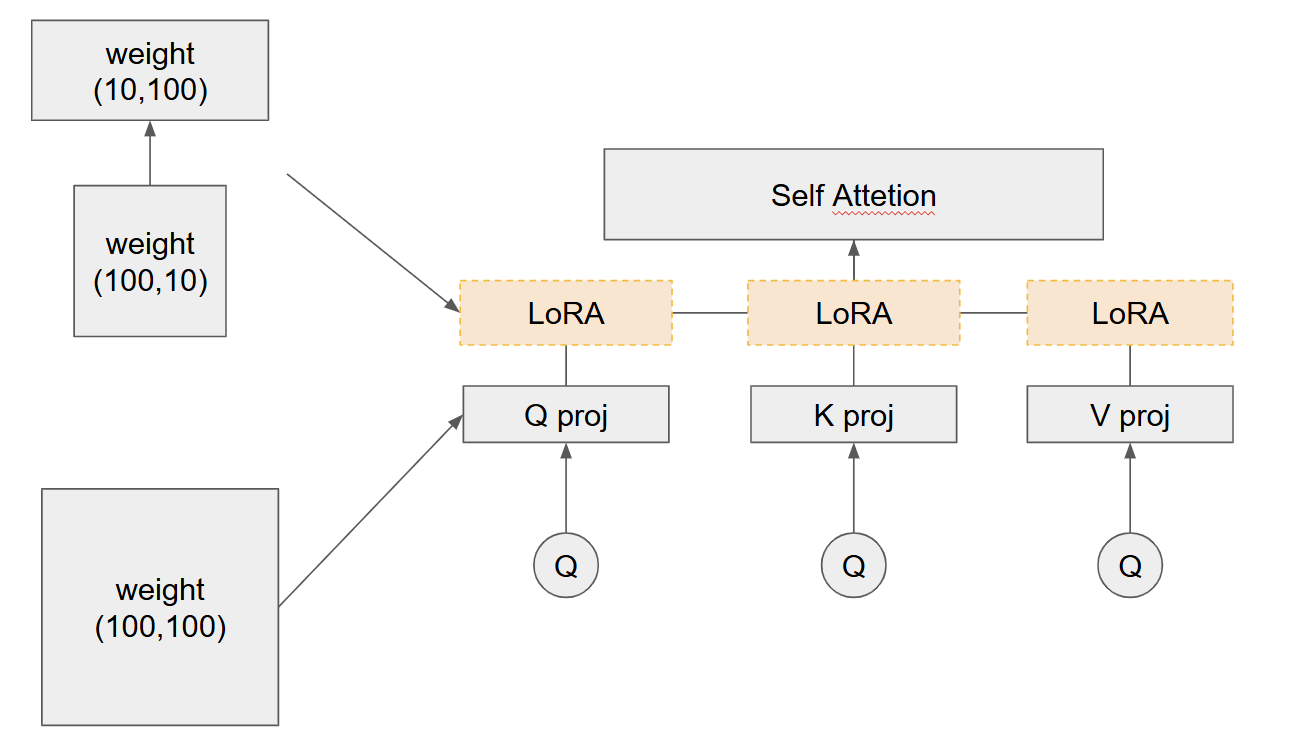

학습이 완료되면 Adapter 층의 분해 행렬을 행렬곱 연산하여 기존 project 레이어와 동일 형상으로 만든뒤 더하기 연산을 통해 가중치를 합칩니다.



허깅페이스에서 Lora 방식으로 미세조정을 하기 위해서 peft 모듈의 `LoraConfig` 객체를 통해 Lora 옵션을 설정해 줍니다.

- r(Rank)

    * LoRA에서 추가 학습 파라미터를 저장할 때 사용되는 저랭크(low-rank) 차원의 크기

    * (hidden_size × hidden_size) => (hidden_size × r) × (r × hidden_size)

    * r이 클수록 모델이 표현할 수 있는 변화(적응) 폭이 커지지만, 그만큼 추가 파라미터가 늘어나고 계산량이 많아짐

- lora_alpha

    * LoRA에서 추가로 학습되는 저랭크 가중치 행렬을 스케일링 하기위한 변수 LoRA출력 × (lora_alpha / r)

    * 모델이 학습 초기에 급격하게 파라미터 업데이트를 하지 않도록 조정하거나, 학습 후반부에 미세한 조정을 가능케 하는 등 학습 안정성과 성능에 영향을 줌

- target_modules

    * LoRA를 삽입할 내부 레이어 계층 이름을 입력

    * LoRA는 주로 어텐션 계층의 선형 레이어(projection)에 삽입하여 활용

    * "all-linear" 를 입력하여 모델의 모든 projection 레이어에 추가 가능


In [ ]:
from peft import LoraConfig
lora_config = LoraConfig(
    r=16,                       # LoRA rank : 저차원 분해의 차원 수, 값이 클수록 표현력 up 학습파라미터 up, 일반적 범위 8~64, 16은 성능과 효율의 균형점
    lora_alpha=8,               # LoRA 스케일링 개수 : 실제 적용 시 (lora_alpha/r) 비율로 적용, 보통 r과 같거나 r/2정도로 설정
    lora_dropout=0.05,          # LoRA 레이어에 적용할 드롭아웃 비율 : 과적합 방지(5%확률로 뉴런 비활성화), 일반적 범위 0.05~0.1
    target_modules=[            # LoRA를 적용할 레이어 지정
        "q_proj",               # Query projection(Attention의 Q)
        "k_proj",               # Key projection(Attention의 K)
        "v_proj",               # Value projection(Attention의 V)
        "o_proj"                # Output projection(Attention의 결과 변환)
    ],                          # Attention의 핵심 4개 가중치 행렬만 튜닝 / MLP는 동결 >> 메모리/시간 절약
    task_type="CAUSAL_LM"       # 테스크 유형: 인과적 언어 모델, gpt 스타일의 자기회귀 생성 모델, 다른 옵션("SEQ_2_SEQ_LM(번역)", "SEQ_CLS(분류)")
)

**LoRA task type (Low-Rank Adaptation)**

- task_type="SEQ_CLS"
    - 시퀀스 분류 (Sequence Classification)
    - 모델: BERT, RoBERTa 등

- task_type="SEQ_2_SEQ_LM"
    - 시퀀스-투-시퀀스 언어 모델링
    - 모델: T5, BART, mT5 등

- task_type="CAUSAL_LM"
    - 인과적(자기회귀) 언어 모델링
    - 모델: GPT, Llama, Gemma 등

https://huggingface.co/learn/smol-course/ko/unit3/2


## PEFT 학습 진행

AutoModelForCausalLM 처럼 교사 주도(supervised) 학습 방식을 사용하는 생성형 모델은 trl 모듈의 `SFTConfig(Supervised Fine-Tuning Config)` 를 통해 하이퍼파라미터를 설정하고 `SFTTrainer`로 쉽게 허깅페이스 프레임에 맞춰 데이터를 학습할 수 있습니다.

BERT 모델 예시에서 사용한 `TrainingArguments`, `Trainer`를 상속하여 확장된 객체이기 때문에 기본적으로 동일한 방식으로 사용하며, 기존 파라미터에 텍스트 생성 모델의 미세조정에 특화된 파라미터를 추가로 활용할 수 있습니다.  


https://huggingface.co/docs/trl/sft_trainer


**SFTConfig 하이퍼파라미터 설정**

TrainingArguments 과 동일한 인자 이름으로 모델 학습에 필요한 하이퍼파라미터를 설정합니다.

- TrainingArguments를 상속받아 확장
- LLM Fine-tuning 특화


In [21]:
from trl import SFTConfig

save_model = "gemma-text-to-sum4"

args = SFTConfig(
    # === 기본 설정 ===
    output_dir=save_model,                  # 학습된 모델을 저장할 폴더 이름
    num_train_epochs=1,                     # 전체 데이터를 몇 번 반복 학습할지 (1번만)
    eval_strategy="no",                     # 평가 전략을 'epoch'으로 설정하여 save_strategy와 일치시킴
    do_eval=False,                          # 평가 활성화

    # === 배치 처리 ===
    per_device_train_batch_size=1,          # GPU가 한 번에 처리할 샘플 개수 (2개씩)
    gradient_accumulation_steps=4,          # 4번 모아서 한 번에 업데이트 (실제로는 2×4=8개)

    # === 메모리 관리 ===
    gradient_checkpointing=False,           # 메모리 절약 기능 끄기 (속도 우선)
    fp16=True,                              # 16비트 사용 (32비트의 절반, 메모리↓ 속도↑)

    # === 학습 속도 ===
    learning_rate=2e-4,                     # 학습 보폭 (0.0002, 한 번에 얼마나 크게 변화)
    optim="adamw_torch_fused",              # 옵티마이저 종류 (학습 방법, 빠른 버전)
    lr_scheduler_type="constant",           # 학습률 고정 (처음부터 끝까지 동일)
    warmup_ratio=0.03,                      # 처음 3%는 천천히 시작 (급발진 방지)

    # === 안정성 ===
    max_grad_norm=0.3,                      # 그래디언트 폭주 방지 (최대 0.3까지만)
    weight_decay=2e-4,                      # 과적합 방지 (가중치 조금씩 줄이기)

    # === 저장 & 로그 ===
    logging_steps=100,                      # 100번마다 진행상황 출력
    save_strategy="epoch",                  # 1 에포크 끝날 때마다 저장
    save_total_limit=2,                     # 최신 2개만 보관 (나머지 삭제)
    load_best_model_at_end=False,           # 학습 끝나면 가장 좋았던 모델 불러오기

    # === 외부 연동 ===
    push_to_hub=False,                      # 허깅페이스에 자동 업로드 안 함
    report_to="none"                        # 외부 실험 추적 도구 안 씀
)

### SFTTrainer 모델 학습

`args`에는 `SFTConfig`을, `peft_config`에는 `LoraConfig`를 입력하여 모델에 Lora 미세조정을 시작합니다. 추가로 토큰의 클래스 정보를 위해 `processing_class` 인자에 토크나이져를 입력합니다.

In [22]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_data,
    peft_config=lora_config,
    processing_class=tokenizer
)

/home/jayden86/miniconda3/envs/codeit_1/lib/python3.10/site-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/jayden86/miniconda3/envs/codeit_1/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [23]:
import torch
import gc

# 1. 가비지 컬렉션 (사용하지 않는 메모리 회수)
gc.collect()

# 2. GPU 캐시 비우기
torch.cuda.empty_cache()

In [24]:
# 학습 시작
trainer.train()

# 모델 저장
trainer.save_model()

/home/jayden86/miniconda3/envs/codeit_1/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
100,2.630200
200,2.386500
300,2.359200
400,2.275000
500,2.238100
600,2.278600
700,2.218100
800,2.208400
900,2.233800
1000,2.246800


## Lora 모델 통합

Lora 미세조정이 완료되면 결과적으로 추가된 Lora 계층 (저차원 분해 행렬 Adapter)의 가중치를 얻게됩니다.

최종 적으로 해당 가중치를 기존 모델에 통합하여 배포 되어야만 미세조정의 결과가 적용된 모델로 활용이 가능합니다.  

In [25]:
import shutil
import os

# 학습된 모델이 저장된 폴더 이름 (위 코드에서 save_model 변수에 경로가 들어있다고 가정)
# 만약 save_model 변수가 없다면, 실제 저장된 폴더명을 문자열로 직접 적어주세요. 예: "gemma-text-to-sum4"
output_zip_name = save_model  # 압축 파일 이름

# 1. 폴더를 zip 파일로 압축
# shutil.make_archive(생성될_파일_이름, 'zip', 압축할_대상_폴더)
shutil.make_archive(output_zip_name, 'zip', save_model)

print(f"압축 완료: {output_zip_name}.zip")
print(f"파일 위치: {os.getcwd()}/{output_zip_name}.zip")

압축 완료: gemma-text-to-sum4.zip
파일 위치: /mnt/nas/jayden_code/Codeit_Practice/Part3_05_PEFT실습/gemma-text-to-sum4.zip


> 약 26MB 크기의 Lora 체크포인트가 만들어집니다.

In [26]:
# 메모리 초기화
del model
del trainer
torch.cuda.empty_cache()

### Lora 가중치 합치기

기존 모델에 Lora 학습 결과를 통합하는 방법은 먼저 Lora의 저차원 분해 행렬을 행렬곱 하여 Lora가 추가되었던 projection 레이어와 동일한 형상으로 맞춰준다음 더하기 연산을 진행합니다.

Lora 가중치 통합을 위해 peft 모듈의 `PeftModel` 객체에서 기본 모델과 저장 경로를 함께 입력하여 불러오고 `merge_and_unload()` 함수를 호출합니다.



In [27]:
from peft import PeftModel

# 기본 모델 로드 (이미 로드 되었다면 생략 가능)
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

model = AutoModelForCausalLM.from_pretrained(
    model_id, quantization_config=quantization_config
).eval()

# 기본 모델에 Lora 가중치 결합 (더하기)
peft_model = PeftModel.from_pretrained(model, save_model)
merged_model = peft_model.merge_and_unload()

# 단일 모델로 저장
merged_model.save_pretrained("merged_model",            # 저장 경로(safetensors)
                             safe_serialization=True,   # 안정적인 저장방식
                             max_shard_size="2GB")      # 셰이딩 저장 단위(용량이 큰경우)

# 토크나이져도 함께 저장 (생략 가능)
processor = AutoTokenizer.from_pretrained(save_model)
processor.save_pretrained("merged_model")

/home/jayden86/miniconda3/envs/codeit_1/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:110: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


('merged_model/tokenizer_config.json',
 'merged_model/special_tokens_map.json',
 'merged_model/chat_template.jinja',
 'merged_model/tokenizer.json')

| 항목 | pickle (.bin) | safetensors (.safetensors) |
|:---:|:---:|:---:|
| **안전성** | ❌ 위험 | ✅ 안전 |
| **속도** | 빠름 | 더 빠름 ✅ |
| **크기** | 보통 | 작음 ✅ |
| **HuggingFace 지원** | 옛날 방식 | 최신 권장 ✅ |
| **코드 실행** | 가능 (위험) | 불가능 ✅ |
| **권장 여부** | ❌ | ✅ |

In [28]:
import shutil
import os

# 1. 압축할 폴더 이름과 생성될 파일 이름 설정
# (이미지의 내용에 따라 'merged_model'로 설정했습니다)
folder_to_zip = 'merged_model'  # 압축 대상 폴더
output_filename = 'merged_model' # 생성될 압축 파일 이름 (확장자 .zip은 자동 추가됨)

# 2. 폴더를 zip 파일로 압축
# shutil.make_archive(저장될_이름, 'zip', 압축할_폴더)
shutil.make_archive(output_filename, 'zip', folder_to_zip)

print(f"압축 완료: {output_filename}.zip")
print(f"파일 저장 위치: {os.getcwd()}/{output_filename}.zip")

압축 완료: merged_model.zip
파일 저장 위치: /mnt/nas/jayden_code/Codeit_Practice/Part3_05_PEFT실습/merged_model.zip


> 약 1GB 크기의 통합 모델이 저장됩니다

In [29]:
import torch
from transformers import pipeline

# Lora 체크포인트에 기본 모델의 정보가 포함되어 같이 불러와짐
# 통합 모델의 경로를 입력해도 사용가능 (merged_model)
my_model = AutoModelForCausalLM.from_pretrained(save_model,device_map='auto').eval()
tokenizer = AutoTokenizer.from_pretrained(save_model)


## 모델 평가

학습된 Lora 가중치를 활용하여 뉴스 요약이 잘 진행되는지 확인해 봅니다.

In [30]:
# 로드된 모델을 활용하는 파이프라인 생성
pipe = pipeline("text-generation", model=my_model, tokenizer=tokenizer)

# 테스트 샘플
test_sample = test_data[100]

# Gemma 템플릿으로 입력 프롬프트 구성
prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:1], tokenize=False, add_generation_prompt=True)
prompt

Device set to use cuda:0


'<bos><start_of_turn>user\n산업부·조달청 정책설명회 정부가 중견기업을 우리 산업의 새로운 성장 엔진으로 육성하기 위해 이들이 생산하는 제품을 공공조달을 통해 적극적으로 활용·육성하기로 했다. 중견기업은 우리나라 전체 공공조달 계약 규모 184조원 중 26조3000억원을 담당하고 있다. 산업통상자원부는 조달청과 함께 1일 서울 마포구 한국중견기업연합회에서 중견기업을 대상으로 공공조달 정책설명회를 개최하고 중견기업 제품의 공공조달 강화방안을 논의했다고 밝혔다. 이날 설명회는 중견기업 지원에 대한 정부인식 제고를 위해 마련된 가운데 조달청은 새 정부의 공공조달 정책방향을 설명했고 참석자들은 중견기업의 공공조달 관련 애로 및 건의 사항을 전달했다. 이종욱 조달청장은 “중견기업은 공공조달 시장 전체 기업 수의 0.7% 3487개 에 불과하지만 우리나라 전체 공공조달 계약 규모 184조원 중 26조3000억원을 담당한다”며 “중견기업이 공공조달 시장에 보다 활발하게 참여하고 국내를 넘어 해외조달시장으로 뻗어나갈 수 있도록 다각적인 지원방안을 강구하겠다”고 말했다. 장영진 사진 산업부 제1차관은 “우리 경제 역동성·활력을 제고하기 위해서는 기업 성장사다리의 핵심 연결고리인 중견기업에 대한 정부 지원체계 강화가 필수적”이라며 “이번 설명회를 시작으로 향후 중견기업계의 주요 애로사항과 관련된 부처를 대상으로 지속적인 소통을 하겠다”고 말했다.<end_of_turn>\n<start_of_turn>model\n'

In [34]:
# 생성을 중단할 토큰 리스트
stop_token_ids = [tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<end_of_turn>")]

# # Generate our SQL query.
outputs = pipe(prompt,
               max_new_tokens=256,              # 생성 토큰 최대 길이
               do_sample=True,                  # 랜덤 샘플링 사용(다양한 후보 생성)
               temperature=0.5,                 # 값이 낮을수록 높은 확률을 가진 후보 선택
               top_k=50,                        # 샘플링에서 고려할 상위 k개 후보
               top_p=0.9,                       # 누적 확률 p 이하의 후보
               eos_token_id=stop_token_ids,     # 끝(중단) 토큰 설정
               disable_compile=False,           # torch.compile() 최적화를 비활성화
               no_repeat_ngram_size=2           # 동일한 엔그램 2번이상 반복 제거
               )
outputs

[{'generated_text': '<bos><start_of_turn>user\n산업부·조달청 정책설명회 정부가 중견기업을 우리 산업의 새로운 성장 엔진으로 육성하기 위해 이들이 생산하는 제품을 공공조달을 통해 적극적으로 활용·육성하기로 했다. 중견기업은 우리나라 전체 공공조달 계약 규모 184조원 중 26조3000억원을 담당하고 있다. 산업통상자원부는 조달청과 함께 1일 서울 마포구 한국중견기업연합회에서 중견기업을 대상으로 공공조달 정책설명회를 개최하고 중견기업 제품의 공공조달 강화방안을 논의했다고 밝혔다. 이날 설명회는 중견기업 지원에 대한 정부인식 제고를 위해 마련된 가운데 조달청은 새 정부의 공공조달 정책방향을 설명했고 참석자들은 중견기업의 공공조달 관련 애로 및 건의 사항을 전달했다. 이종욱 조달청장은 “중견기업은 공공조달 시장 전체 기업 수의 0.7% 3487개 에 불과하지만 우리나라 전체 공공조달 계약 규모 184조원 중 26조3000억원을 담당한다”며 “중견기업이 공공조달 시장에 보다 활발하게 참여하고 국내를 넘어 해외조달시장으로 뻗어나갈 수 있도록 다각적인 지원방안을 강구하겠다”고 말했다. 장영진 사진 산업부 제1차관은 “우리 경제 역동성·활력을 제고하기 위해서는 기업 성장사다리의 핵심 연결고리인 중견기업에 대한 정부 지원체계 강화가 필수적”이라며 “이번 설명회를 시작으로 향후 중견기업계의 주요 애로사항과 관련된 부처를 대상으로 지속적인 소통을 하겠다”고 말했다.<end_of_turn>\n<start_of_turn>model\n중중강기업 연합회가 정부와 조 달청이 중주기업 공정거래를 위한 정책을 마련하고 정부는 공중조 달 시장의 전체 8.3%를 담당하는 중중기업 5470개 중 중장기 전망 4.5%에 불어난 중기 경제 성장 동력으로 중반기 중소기업 수출 증대 및 중대형 중공업 산업 육성을 위해 중강 기업의 중간 시장을 활용하고 공업 분야의 산업 성장을 촉진하기 위한 중점 정책과 공익조직을 지원하고 기획재정부의 정책 방향을 제시했다는 내용이다.

In [ ]:
outputs[0]['generated_text'].strip('<start_of_turn>model')[1]

'o'

: 